In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
data = pd.read_csv('bbc_cleaned.csv')

2.1 Factorization

First, let's factorize the "topic" column -

In [41]:
data['topic_id'] = data.topic.factorize()[0]
print(data.head())
print(data.shape)

                                                text     topic  topic_id
0  dallaglio man end controversy lawrence dallagl...     sport         0
1  best person legal job best person job appoint ...  politics         1
2  viewers able shape tv imagine edit titanic wat...      tech         2
3  fox attack blair tory lie tony blair lie take ...  politics         1
4  microsoft debut security tool microsoft releas...      tech         2
(2118, 3)


We will now take a look at how the Product topics are mapped and then also create couple dictionaries from the same for future reference (mapping topics to factors and vice-versa) -

In [42]:
data['topic_id'] = data['topic'].factorize()[0]

topic_id_df = data[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'topic']].values)

print(topic_id_df)
print(topic_to_id)
print(id_to_topic)  

            topic  topic_id
0           sport         0
1        politics         1
2            tech         2
5        business         3
18  entertainment         4
{'sport': 0, 'politics': 1, 'tech': 2, 'business': 3, 'entertainment': 4}
{0: 'sport', 1: 'politics', 2: 'tech', 3: 'business', 4: 'entertainment'}


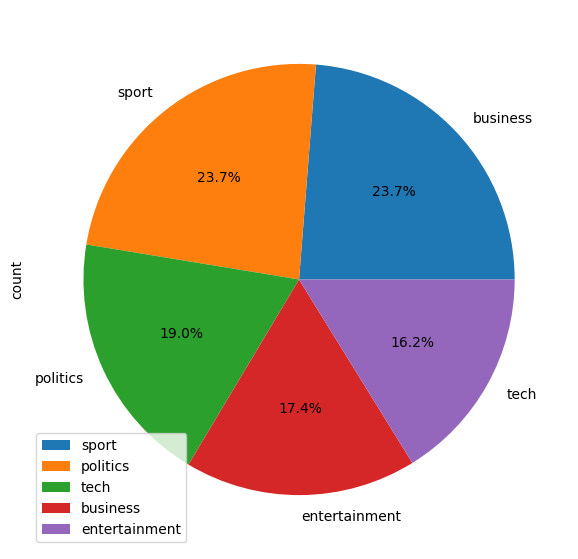

In [43]:
list_topic = data["topic"].unique()
data["topic"].value_counts().plot(kind = 'pie',figsize = (7, 7), autopct = '%1.1f%%', shadow = False)

plt.legend(list_topic)
plt.show()

Distribution of Data

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7824\3662893941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


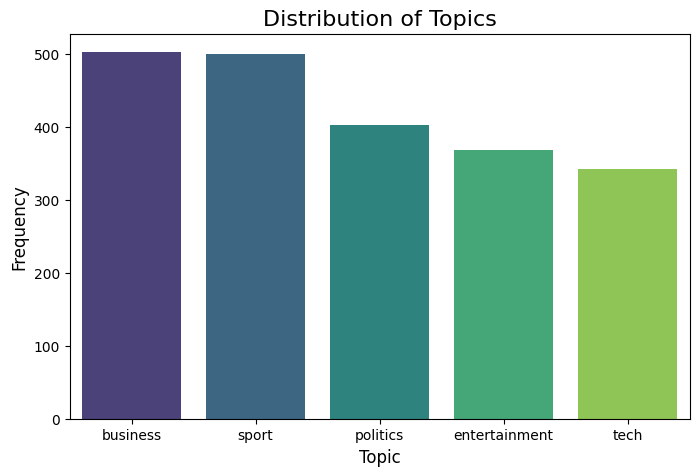

Phân phối các chủ đề:
topic
business         503
sport            501
politics         403
entertainment    368
tech             343
Name: count, dtype: int64
Duplicates:  0


In [44]:
import seaborn as sns

# Step 1: Distribution of Topics
topic_counts = data['topic'].value_counts()

# Bar chart for topic distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title('Distribution of Topics', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.show()

# In số liệu phân phối các chủ đề
print("Phân phối các chủ đề:")
print(topic_counts)

# Step 2: Check for Duplicates
duplicates = data.duplicated(subset=['text'], keep=False).sum()

# Output number of duplicates for reference
print("Duplicates: ", duplicates)


Here, we see that the number of articles per topic is roughly balanced, which is helpful! If our dataset were imbalanced, we would need to carefully configure our model or artificially balance the dataset

To further analyze our dataset, we need to transform each article's text to a feature vector, a list of numerical values representing some of the text’s characteristics. This is because most ML models cannot process raw text, instead only dealing with numerical values.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. This statistic represents words’ importance in each document. We use a word's frequency as a proxy for its importance. 

We also use the document frequency (the number of documents containing a given word) as a measure of how common the word is. This minimizes the effect of stop-words such as pronouns, or domain-specific language that does not add much information.

2. Word Cloud

Now, let's build a topico demonstrate which are the most frequent terms for each of the categories. This will give us a brief idea if there are any frequent words that separate our data up to some extent.

In [45]:
data.topic.unique()

array(['sport', 'politics', 'tech', 'business', 'entertainment'],
      dtype=object)

In [46]:
tech = ' '.join(list(data.text[data.topic == 'tech']))
business = ' '.join(list(data.text[data.topic == 'business']))
sport = ' '.join(list(data.text[data.topic == 'sport']))
entertainment = ' '.join(list(data.text[data.topic == 'entertainment']))
politics = ' '.join(list(data.text[data.topic == 'politics']))

The code filters and combines text from the data DataFrame by topic (e.g., 'tech', 'business', 'sport', etc.), creating a single string for each topic. This is typically done to generate word clouds for each category, allowing visual analysis of the most frequent terms within each topic.

Word Cloud by Topic

In [47]:
from wordcloud import WordCloud

def wordcloud(text, title):
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        background_color = "black",
        min_font_size = 10
    ).generate(text)

    plt.figure(figsize = (16, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.title("Word Cloud for " + title + " Articles\n", fontsize = 20)
    plt.axis("off")
    plt.show()

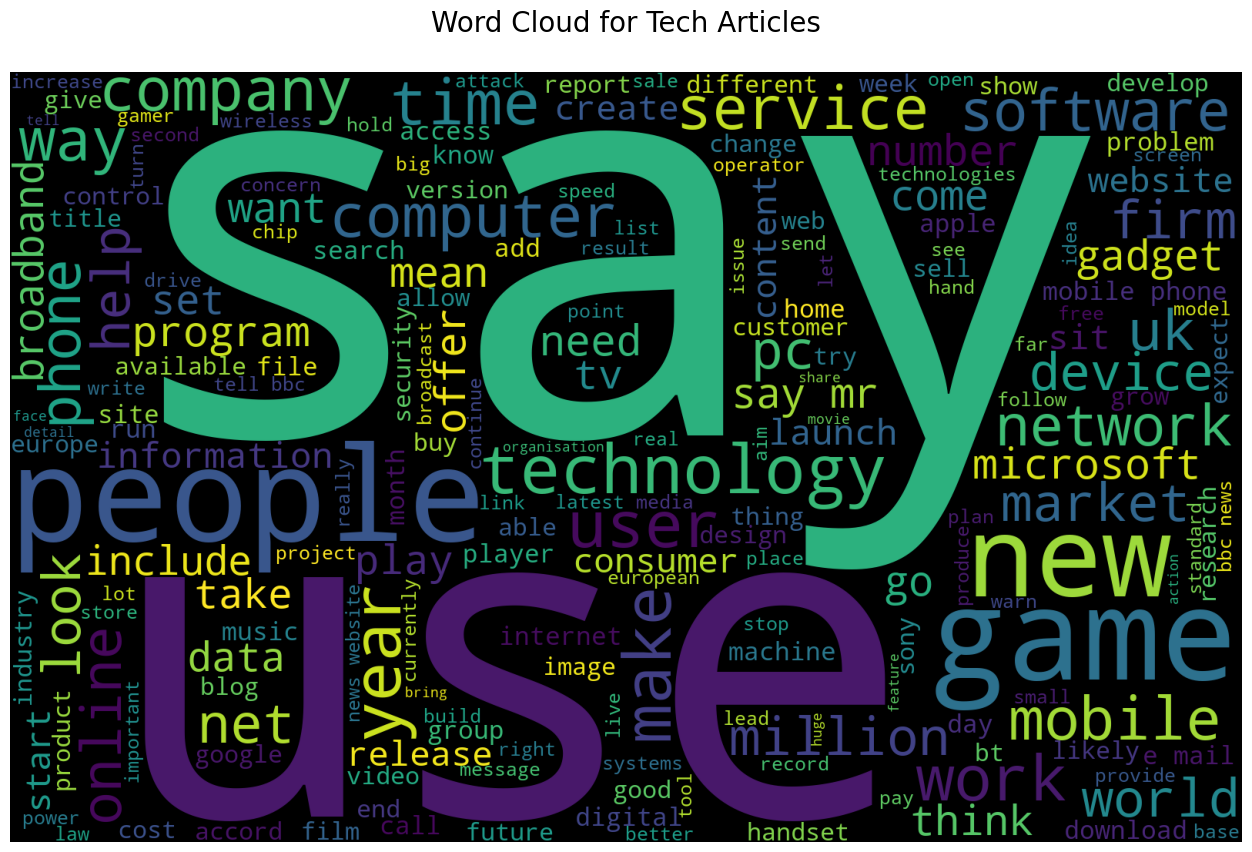

In [48]:
wordcloud(tech, "Tech")

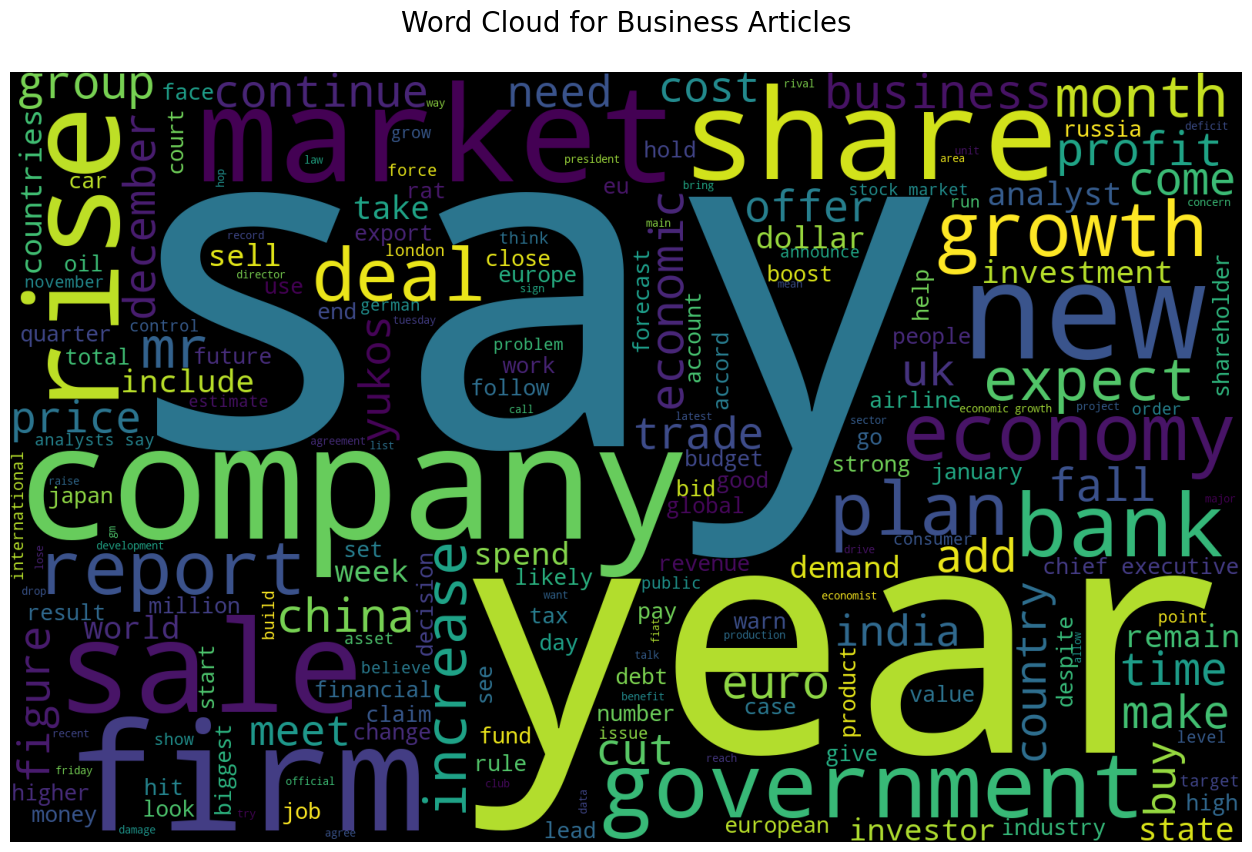

In [49]:
wordcloud(business, "Business")

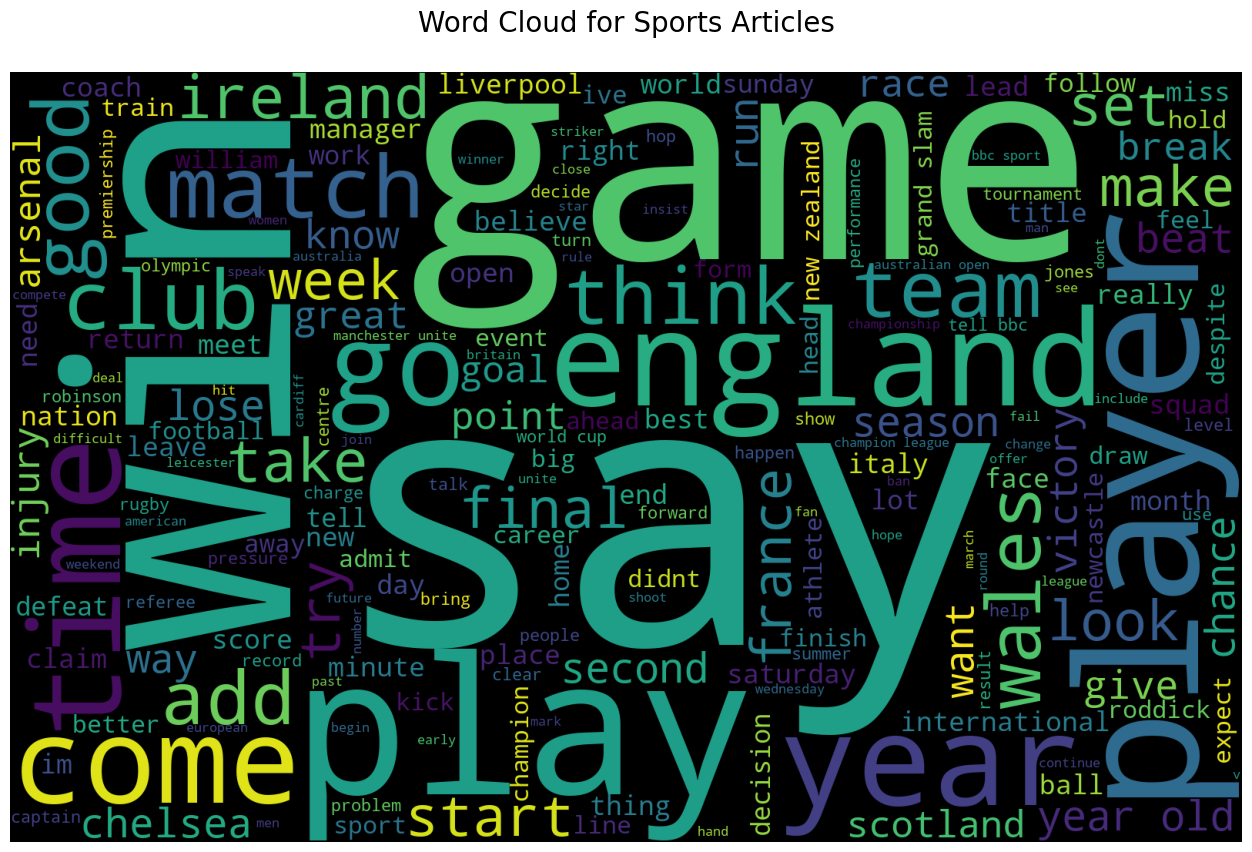

In [50]:
wordcloud(sport, "Sports")

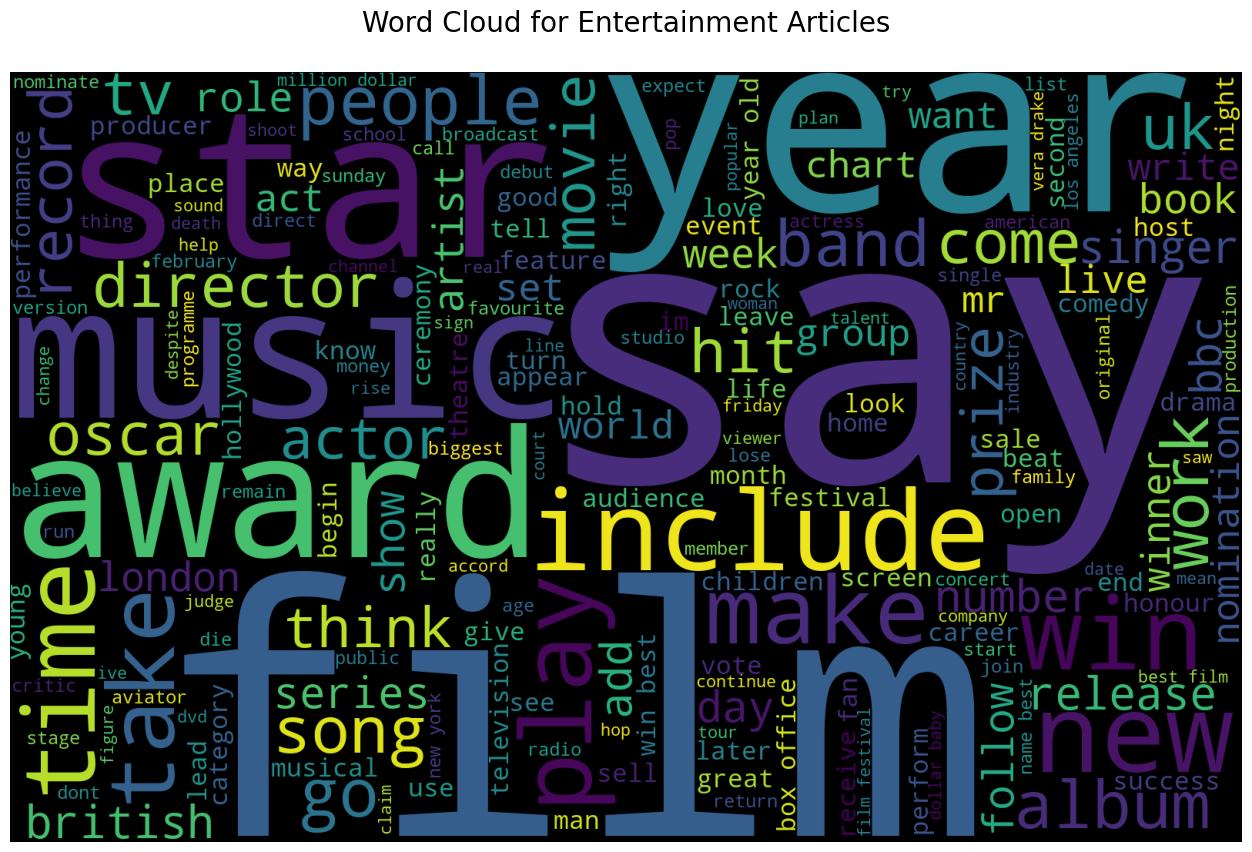

In [51]:
wordcloud(entertainment, "Entertainment")

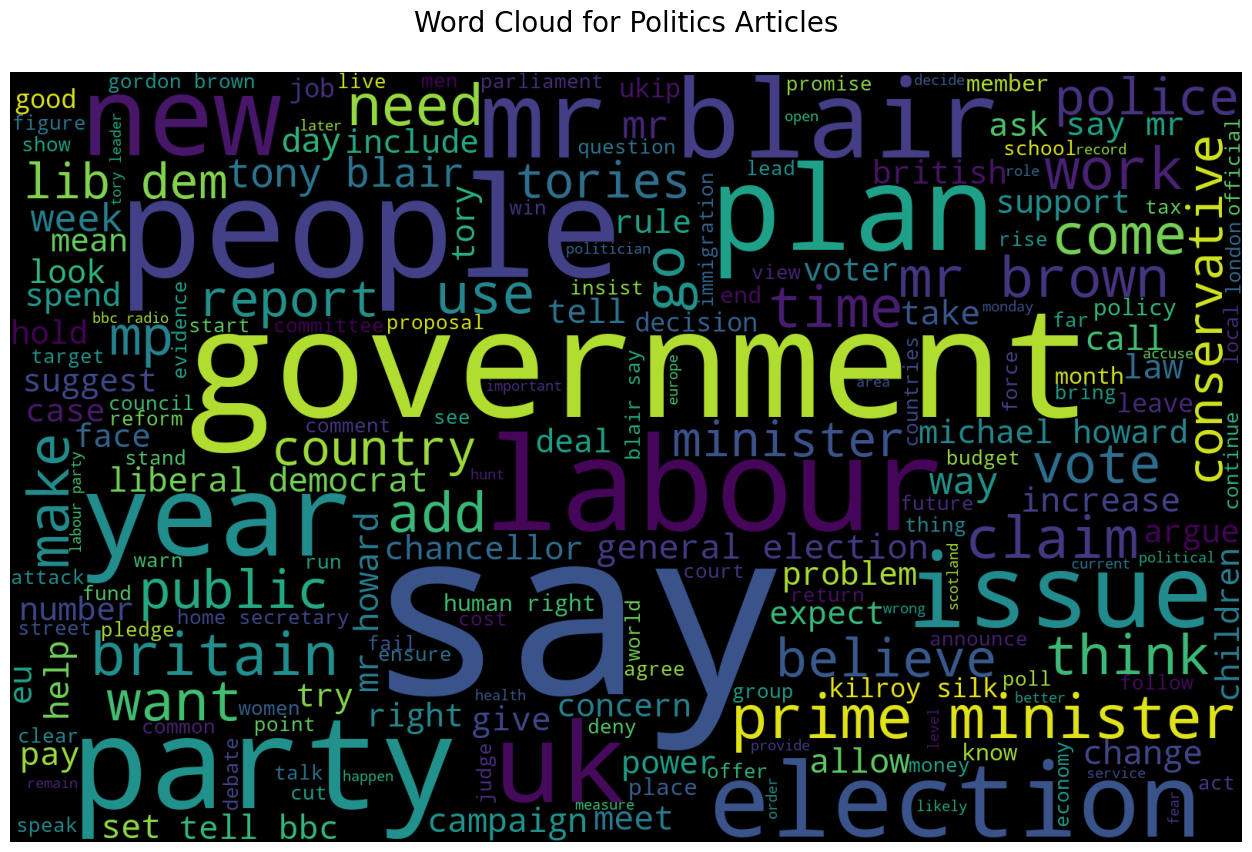

In [52]:
wordcloud(politics, "Politics")

From all of the above word clouds, we make the following observations -
* The word **say** is very frequent in each of the articles In fact it is most frequent in almost every topic of article.
* For **tech** related articles, the words like ***people, technology, computer, software*** are frequent.
* For **business** related articles, the words like ***market, growth, company, firm*** are frequent.
* For **sport** related articles, the words like ***game, match, player, team, win*** are frequent.
* For **entertainment** related articles, the words like ***film, show, music, award, band*** are frequent.
* For **politics** related articles, the words like ***people, plan, labour, government*** are frequent.
One thing that might worry us is that the word said is too prevalent in the entire dataset and could lead to some sort of bias. We can be pretty certain that there might not be the case. Why? Because the word is just too prevalent and hence a poor separator of our data. We will verify this in the next step when we will take a look at some of the most relevant words/terms to each of our categories.

For that purpose, we will adapt a very beautfully written code by Susan Li in [this article](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f).

What we will be doing is using chi-squared test to identify the 2 unigrams and bigrams each that are most relevant to each of the categories. For conducting a chi-squared test, we will need to vectorize our text data first so let's get to it.
P.S. I have written a more detailed explanation for the above mentioned code for easy understanding below.

2.4 Feature Engineering

When it comes to text data and text analytics in general, feature engineering is converting text data into features which can be used by algorithms i.e. converting text into meaningful numbers.
There are many methods to achieve that viz. Tokenization, Vectorization, etc.
We will make use of TF-IDF (Term Frequency, Inverse Document Frequency) vectorization to generate features out of our data i.e. the complaints.
tf-idf vectorization is a technique in which each term in a document and hence the corpus is assigned a weight based on it's frequency. It has two terms.
Term Frequency - This measures the term frequency for each document.

TF = (number of times term e appears in the document) / (total number of words in the document)

Inverse Document Frequency - This measures how important a term is w.r.t. the entire corpus. TF considers all terms equal hence terms which are more frequent like "is", "was", etc. will have a higher TF than more important, but rarer, words like "hazardous", "experiment", etc. IDF scales such rare words up and scales the more frequent words down so as to balance them both.

IDF = ln(number of total documents / number of documents having the term e)

We then calculate the TF-IDF by simply multiplying both the terms above 

TF-IDF = TF x IDF


We will use sklearn (also known as scikit-learn), a machine learning library that is particularly accessible to beginners. We use the TfidfVectorizer class to calculate a tf-idf vector for each of our documents:

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data['text']).toarray()
labels = data.topic_id
print(features.shape) 

(2118, 12526)


Each of our 2118 documents is now represented by 12542 features, representing the tf-idf score for different unigrams and bigrams.

This representation is not only useful for solving our classification task, but also to familiarize ourselves with the dataset. For example, we can use the chi-squared test to find the terms are the most correlated with each of the topics.

## Chi-Squared Formula

The chi-squared statistic is calculated as:

$$
\chi^2 = \sum_{i=1}^{n} \frac{(O_i - E_i)^2}{E_i}
$$

$$
\text{Where:}
$$

$$
O_i \text{ is the observed frequency.}
$$

$$
E_i \text{ is the expected frequency.}
$$


In [54]:
from sklearn.feature_selection import chi2  # Import chi-squared test
import numpy as np 
N = 5  # Set the number of top features to display

# Loop through each topic and calculate chi-squared scores
for topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)  # Calculate chi-squared values
    indices = np.argsort(features_chi2[0])  # Sort features by chi-squared values
    feature_names = np.array(tfidf.get_feature_names_out())[indices]  # Get feature names
    
    # Separate unigrams (single words) and bigrams (two words)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    # Print the most correlated unigrams and bigrams for the current topic
    print("# '{}':".format(topic))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))


# 'business':
  . Most correlated unigrams:
       . profit
       . economy
       . oil
       . growth
       . bank
  . Most correlated bigrams:
       . chief executive
       . oil price
       . economic growth
       . stock market
       . analysts say
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . star
       . award
       . film
  . Most correlated bigrams:
       . best film
       . los angeles
       . film festival
       . win best
       . box office
# 'politics':
  . Most correlated unigrams:
       . tory
       . party
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . michael howard
       . prime minister
       . general election
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . injury
       . champion
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . world cup
       . year old
       . champion league
       . aust

> * Going through the features above, we can see that almost all of them make a lot of sense. 
> * Also, no mentions of the word **"say"** as discussed above.

These result are consistent with what we would expect from a news outlet. We also notice that the addition of bigrams is welcome since it catches pairs of words that only make sense when put together (economic growth, box office, ...). Simply using this correlation factor to predict which class is the most likely might already get us quite far, but we will see that there are simpler and more efficient ways to do this.

- The initial test shows that certain terms are specific to each category, but there may be too much noise in the data, making it hard to separate the categories clearly. To check if the feature space is suitable for classification, we can apply dimensionality-reduction techniques, which reduce high-dimensional data to a lower number of dimensions.
    * PCA and Truncated SVD are popular methods due to their scalability, but they may struggle with non-linear relationships in the data.
    * Kernel PCA, self-organizing maps, and auto-encoders are better for handling non-linear correlations.
- Given that our data involves natural language, which typically has non-linear correlations, we will use t-SNE, a technique commonly used in NLP, to reduce the dimensionality.

Explain t-SNE:

- t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique, particularly effective in preserving local relationships between data points in high-dimensional spaces. It maps high-dimensional data into 2 or 3 dimensions for visualization, often used in NLP and image processing tasks.


### What the above code does -
- Line 4 - A loop is initiated to iterate through each topic, using the topic_to_id dictionary, which contains topics and their corresponding unique IDs.
- Line 5 - For each topic, the chi-squared test (chi2) is applied to measure the correlation between each feature and the current topic. The result consists of two arrays: one for the chi-squared values and another for the p-values, though only the chi-squared values are used here.
- Line 6 - The chi-squared values are sorted in ascending order using np.argsort(), which returns the indices of the sorted values.
- Line 7 - The feature names (terms from the TF-IDF vectorizer) are retrieved, and they are sorted based on the indices from the previous step. This way, the features are ordered by their chi-squared values.
- Line 8, 9 - The features are then separated into unigrams (single words) and bigrams (pairs of words) based on the length of the feature (unigrams have one word, and bigrams have two words).
- Line 10, 11, 12 - The top N most correlated unigrams and bigrams are printed for the current topic. The N most important features (unigrams and bigrams) are displayed by slicing the sorted feature list. This allows identifying the most significant terms for each topic.

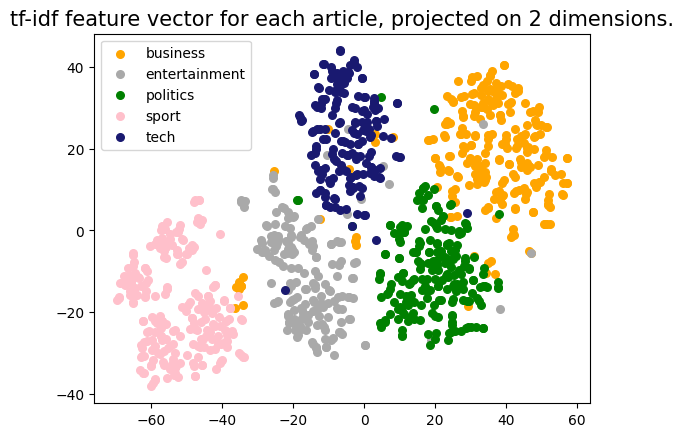

(1059, 2)
(2118, 12526)


In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.5)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)

# Adjusted random_state to 42
projected_features = TSNE(n_components=2, random_state=42).fit_transform(features[indices])

colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for topic, topic_id in sorted(topic_to_id.items()):
    points = projected_features[(labels[indices] == topic_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[topic_id], label=topic)

plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()
plt.show()

print(projected_features.shape)
print(features.shape)